# Тема: Рекомендация исполнителей для выполнения контрактов с учетом пространственного расположения контрагентов

# парсинг spark

In [ ]:
!pip3 install selenium

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 9.5/9.5 MB 13.8 MB/s eta 0:00:00
     ------------------------------------- 467.2/467.2 kB 28.6 MB/s eta 0:00:00
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.11.0 which is incompatible.


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import WebDriverException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
import pandas as pd
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException

In [ ]:
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('-headless')
    options.add_argument('-disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

In [ ]:
credinals = [['FAUNIVER123','HCKoqZ1'],
             ['FAUNIVER124','kLC02oo'],
             ['FAUNIVER125','wcKoepi'],
             ['FAUNIVER210','cneltyn21'],
             ['FAUNIVER53','cjkjdtq5'],
             ['FAUNIVER54','dtiyzrb4'],
             ['FAUNIVER59','YHRop123'],
             ['FAUNIVER134','0m40/3y'],
             ['FAUNIVER214','SL8cGBP1']]

In [ ]:
company = pd.read_csv("C:/Users/VPlibrary/Downloads/spark_top50k.csv").drop(columns=['Выручка, ₽'])
company

,Наименование,ИНН
0,"ПАО ""НК ""РОСНЕФТЬ""",7706107510
1,"ПАО ""ГАЗПРОМ""",7736050003
2,"ПАО ""ГАЗПРОМ НЕФТЬ""",5504036333
3,"ПАО ""ЛУКОЙЛ""",7708004767
4,"ОАО ""РЖД""",7708503727
...,...,...
50995,"ООО ""ЭСКОРТ ГРУПП""",7722697432
50996,"ООО ""ТД-АС""",7723591855
50997,"ООО ""ЙОСТ ТАТ""",1650167023
50998,"ООО ""САФАРИПАРК""",2304058310


In [ ]:
login, password = credinals[6][0], credinals[6][1]

In [ ]:
driver = web_driver()

In [ ]:
def auth(driver, login, password):
    try:
        driver.get("https://spark-interfax.ru/#/dashboard")

        login_input = driver.find_element(By.NAME,'username')
        login_input.clear()
        login_input.send_keys(login)
        time.sleep(2)

        password_input = driver.find_element(By.NAME,'password')
        password_input.clear()
        password_input.send_keys(password)
        time.sleep(2)

        login_button = driver.find_element(By.XPATH, '//button[@class="btn btn-primary btn-sm login-form__btn"]').click()
        time.sleep(5)

        return driver

    except Exception as ex:
        print(ex)


In [ ]:
driver = auth(driver, login, password)

In [ ]:
def element_present(path, driver, many = False, timeout=20):
    try:
        element_present = EC.presence_of_element_located((By.XPATH, path))
        WebDriverWait(driver, timeout).until(element_present)
        if not many:
            return driver.find_element(By.XPATH, path)
        else: return driver.find_elements(By.XPATH, path)
    except Exception:
        print("Timed out waiting for page to load")

In [ ]:
def find_company(name, itn, driver):
    for _ in range(5):
        try:
            current_company = 0
            find_company = element_present('//input[@class="form-control search-input js-search-input js-unknown-input js-autocompleted js-immediate-search js-tooltip tt-input"]', driver = driver)
            find_company.send_keys(name)

            search_button = element_present('//button[@class="btn sp-search-btn js-btn-search dropdown-toggle"]', driver = driver).click()

            company_containers = element_present('//div[@class="sp-list-summary__item"]', driver = driver, many = True)

            for container in company_containers:

                inner_element = element_present('.//span[@class="bold"]', driver=container)
                if itn == int(inner_element.text):
                    current_company = container
                    print(f'Найдена нужная компания: {name}')
                    break

            assert current_company != 0, f'Не найден контейнер, содержащий информацию о {name}'
            company_path = element_present('.//a', driver = current_company).get_attribute('href')
            return company_path
        except StaleElementReferenceException:
            print("Элемент устарел, попробуем еще раз")

In [ ]:
def save_dataset(name, data):
    df = pd.DataFrame(data, columns=['Компания', 'Общая тема', 'Подтема', 'Заголовок', 'Новость'])
    df.to_csv(name)

In [ ]:
driver.get("https://spark-interfax.ru/#/dashboard")
company_path = find_company(company['Наименование'].values[0], 0)
driver.get(company_path)
menu_containers = element_present('//button[@class="sp-fake-link card-menu-items__item"]', many = True)
for container in menu_containers:
    if element_present('.//div[@class="btn__inner"]', driver = container).text == 'Публикации в СМИ':
        break
container.click()

AssertionError: Не найден контейнер, содержащий информацию о ПАО "НК "РОСНЕФТЬ"

In [ ]:
def parsing_for_current_company(company_path, driver):
    themes=None
    sub_themes=None
    news_values=None

    driver.get(company_path)
    menu_containers = element_present('//button[@class="sp-fake-link card-menu-items__item"]', driver = driver, many = True)
    for container in menu_containers:
        if element_present('.//div[@class="btn__inner"]', driver = container).text == 'Публикации в СМИ':
            break
    container.click()

    news = {}

    themes = element_present('//table[@class="mass-media-themes"]', driver = driver, many = True)

    if themes:
        print('    Найдены общие темы новостей')

    for i in range(len(themes)):
        sub_themes = element_present('.//button[@class="sp-fake-link mass-media-themes-button"]', driver = themes[i], many = True)
        sub_news = {}

        if sub_themes:
            print('        Найдены подтемы новостей')

        for j in range(len(sub_themes)):
            name = sub_themes[j].text.split('\n')[0]
#             print(name)

            sub_themes[j].click()
            news_values = element_present('//table[@class="publication-preview"]', driver = driver, many = True)

            news_text = []
            for values in news_values:
                news_text.append([element_present('.//div[@class="btn__inner"]', driver = values).text, element_present('.//div[@class="publication-preview__content"]', driver = values).text])

            driver.execute_script("window.history.go(-1)")

            container.click()

            themes = element_present('//table[@class="mass-media-themes"]', driver = driver, many = True)
            sub_themes = element_present('.//button[@class="sp-fake-link mass-media-themes-button"]', driver = themes[i], many = True)

            sub_news[name] = news_text
        news[element_present('.//span[@class="bold"]', driver = themes[i]).text] = sub_news
#         print()

    return news

In [ ]:
from tqdm import tqdm

In [ ]:
driver = web_driver()
driver = auth(driver, credinals[0][0], credinals[0][1])

In [ ]:
def parsing(company, idx = 0, driver = driver):
    rows = []
    error_limit_count = 15
    exception_count = 0
    success_parsing = 0
    succes_limit_count = 10
    auth_errors = 0

    error_element = element_present('//span[@class="js-error-text-container"]', driver = driver)
    while error_element:
        auth_errors+=1
        print(error_element.text)
        driver = auth(driver, credinals[auth_errors%8][0], credinals[auth_errors%8][1])
        error_element = element_present('//span[@class="js-error-text-container"]', driver = driver)
        if auth_errors == 8:
            time.sleep(60*30)
    print(f'Авторизация пользователем "{credinals[auth_errors%8][0]}" успешна')

    for i, (name, itn) in enumerate(tqdm(company[idx:])):
        try:
            driver.get("https://spark-interfax.ru/#/dashboard")
            company_path = find_company(name, itn, driver)
            driver.get(company_path)
            menu_containers = element_present('//button[@class="sp-fake-link card-menu-items__item"]', driver = driver, many = True)
            for container in menu_containers:
                if element_present('.//div[@class="btn__inner"]', driver = container).text == 'Публикации в СМИ':
                    break
            container.click()

            news = parsing_for_current_company(company_path, driver)
            exception_count = 0

            data = {}
            data[name] = news

            for comp, general_topics in data.items():
                for general_topic, sub_topics in general_topics.items():
                    for sub_topic, all_news in sub_topics.items():
                        for news in all_news:
                            rows.append([comp, general_topic, sub_topic, news[0], news[1]])

            success_parsing += 1

            if success_parsing%succes_limit_count == 0:
                save_dataset(f'Датасет {success_parsing} компаний.csv',rows)
                print(f'Сохраним новости по {success_parsing} компаниям')

        except Exception as ex:
            exception_count += 1
            print(ex)
            try:
                error_element = element_present('//span[@class="js-error-text-container"]', driver = driver, timeout=2)
                if error_element.text == '':
                    while error_element:
                        auth_errors+=1
                        print(error_element.text)
                        driver = auth(driver, credinals[auth_errors%8][0], credinals[auth_errors%8][1])
                        error_element = element_present('//span[@class="js-error-text-container"]', driver = driver)
                        if auth_errors == 8:
                            time.sleep(60*30)
                    print(f'Релогин пользователем "{credinals[auth_errors%8][0]}" выполнен успешно')
            except Exception as ex:
                print('Ошибка не в истекшей сессии')

            if exception_count == error_limit_count:
                save_dataset(f'Датасет {success_parsing} компаний.csv',rows)
                print(f'Преждевременный выход из цикла на {i} итерации. Количество ошибок подряд превысило {error_limit_count}')
                return i

    return rows

In [ ]:
rows = parsing([['ПАО "НК "РОСНЕФТЬ"', 0],['ПАО "НК "РОСНЕФТЬ"', 7706107510], ['ПАО "НК "РОСНЕФТЬ"', 0],['ПАО "НК "РОСНЕФТЬ"', 0]])

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Не найден контейнер, содержащий информацию о ПАО "НК "РОСНЕФТЬ"


 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.95s/it]

Timed out waiting for page to load
Ошибка не в истекшей сессии
Найдена нужная компания: ПАО "НК "РОСНЕФТЬ"
    Найдены общие темы новостей
        Найдены подтемы новостей
        Найдены подтемы новостей
        Найдены подтемы новостей


 50%|██████████████████████████████████████████                                          | 2/4 [00:26<00:29, 14.67s/it]

Не найден контейнер, содержащий информацию о ПАО "НК "РОСНЕФТЬ"


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:30<00:09,  9.78s/it]

Timed out waiting for page to load
Ошибка не в истекшей сессии
Элемент устарел, попробуем еще раз
Не найден контейнер, содержащий информацию о ПАО "НК "РОСНЕФТЬ"


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.67s/it]

Timed out waiting for page to load
Ошибка не в истекшей сессии


In [ ]:
df = pd.DataFrame(rows, columns=['Компания', 'Общая тема', 'Подтема', 'Заголовок', 'Новость'])

df

,Компания,Общая тема,Подтема,Заголовок,Новость
0,"ПАО ""НК ""РОСНЕФТЬ""","Суды, конфликты, расследования",Взятки,"В уголовном деле о взятке сотрудника ""дочки"" ""...",…До суда подозреваемый отправлен в СИЗО Фото: ...
1,"ПАО ""НК ""РОСНЕФТЬ""","Суды, конфликты, расследования",Взятки,"В уголовном деле о взятке сотрудника ""дочки"" ""...",… В уголовном деле сотрудника дочернего предпр...
2,"ПАО ""НК ""РОСНЕФТЬ""",Другие происшествия,Падение курса акций,Рынок акций РФ упал к 3440п по индексу МосБирж...,"…Так, ожидается, что основной его целью будет ..."
3,"ПАО ""НК ""РОСНЕФТЬ""",Другие происшествия,Падение курса акций,Рынок акций РФ начал неделю с умеренного сниже...,"…Доллар к 18:50 МСК просел до 91,23 рубля (- 0..."
4,"ПАО ""НК ""РОСНЕФТЬ""",Другие происшествия,Падение курса акций,"Рынок акций РФ в пятницу стабилизировался, выр...","…""Газпром"" расстроил рынок новостями о получен..."
...,...,...,...,...,...
288,"ПАО ""ГАЗПРОМ""",Деловая тематика,Экспорт газа,"""Газпром"" впервые за 25 лет получил чистый убыток","…Ожидалось, что EBITDA составит около 2,2 трлн..."
289,"ПАО ""ГАЗПРОМ""",Деловая тематика,Экспорт газа,Молдавия позволит Приднестровью покупать росси...,…Осло уже оказывает финансовую поддержку Молда...
290,"ПАО ""ГАЗПРОМ""",Деловая тематика,Экспорт газа,В Молдавии спрогнозировали резкое снижение цен...,…Максимальная теплотворность (количество тепло...
291,"ПАО ""ГАЗПРОМ""",Деловая тематика,Экспорт газа,Самарская область приняла участие во Всероссий...,"…""Мы искренне благодарим нашего национального ..."


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Датасет 89 компаний.csv')

In [ ]:
df

,Unnamed: 0,Компания,Общая тема,Подтема,Заголовок,Новость
0,0,"ПАО ""НК ""РОСНЕФТЬ""","Суды, конфликты, расследования",Взятки,"В уголовном деле о взятке сотрудника ""дочки"" ""...",…До суда подозреваемый отправлен в СИЗО Фото: ...
1,1,"ПАО ""НК ""РОСНЕФТЬ""","Суды, конфликты, расследования",Взятки,"В уголовном деле о взятке сотрудника ""дочки"" ""...",… В уголовном деле сотрудника дочернего предпр...
2,2,"ПАО ""НК ""РОСНЕФТЬ""",Другие происшествия,Падение курса акций,Рынок акций РФ упал к 3440п по индексу МосБирж...,"…Так, ожидается, что основной его целью будет ..."
3,3,"ПАО ""НК ""РОСНЕФТЬ""",Другие происшествия,Падение курса акций,Рынок акций РФ начал неделю с умеренного сниже...,"…Доллар к 18:50 МСК просел до 91,23 рубля (- 0..."
4,4,"ПАО ""НК ""РОСНЕФТЬ""",Другие происшествия,Падение курса акций,"Рынок акций РФ в пятницу стабилизировался, выр...","…""Газпром"" расстроил рынок новостями о получен..."
...,...,...,...,...,...,...
2379,2379,"ПАО НК ""РУССНЕФТЬ""",Деловая тематика,Строительство,"""РуссНефть"" завершила модернизацию инфраструкт...","… ПАО НК ""РуссНефть"" завершило модернизацию ин..."
2380,2380,"ПАО НК ""РУССНЕФТЬ""",Деловая тематика,Транспортировка нефтепродуктов,Оборот нефтебензиновых цистерн на сети РЖД уск...,…В пресс-службах Минтранса и Минпромторга запр...
2381,2381,"ПАО НК ""РУССНЕФТЬ""",Деловая тематика,Транспортировка нефтепродуктов,РуссНефть модернизировала инфраструктуру Нижне...,"…Акционеры на 31 января 2024 года: ОАО ИК ""Над..."
2382,2382,"ПАО НК ""РУССНЕФТЬ""",Деловая тематика,Транспортировка нефтепродуктов,"""РуссНефть"" модернизировала инфраструктуру Ниж...",…Цель программы по диверсификации объектов тра...


In [ ]:
df[['Компания','Заголовок']]

,Компания,Заголовок
0,"ПАО ""НК ""РОСНЕФТЬ""","В уголовном деле о взятке сотрудника ""дочки"" ""..."
1,"ПАО ""НК ""РОСНЕФТЬ""","В уголовном деле о взятке сотрудника ""дочки"" ""..."
2,"ПАО ""НК ""РОСНЕФТЬ""",Рынок акций РФ упал к 3440п по индексу МосБирж...
3,"ПАО ""НК ""РОСНЕФТЬ""",Рынок акций РФ начал неделю с умеренного сниже...
4,"ПАО ""НК ""РОСНЕФТЬ""","Рынок акций РФ в пятницу стабилизировался, выр..."
...,...,...
2379,"ПАО НК ""РУССНЕФТЬ""","""РуссНефть"" завершила модернизацию инфраструкт..."
2380,"ПАО НК ""РУССНЕФТЬ""",Оборот нефтебензиновых цистерн на сети РЖД уск...
2381,"ПАО НК ""РУССНЕФТЬ""",РуссНефть модернизировала инфраструктуру Нижне...
2382,"ПАО НК ""РУССНЕФТЬ""","""РуссНефть"" модернизировала инфраструктуру Ниж..."


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
news_clustering = dict(zip(df['Заголовок'],df['Общая тема']))

In [ ]:
G = nx.from_pandas_edgelist(df, 'Компания', 'Заголовок')

colors = []
mask = {'Деловая тематика':'red',
        'Другие происшествия':'green',
        'Корпоративные проблемы':'pink',
        'Суды, конфликты, расследования':'purple'}

for node in G.nodes:
    if node in df['Компания'].values:
        colors.append('lightblue')
    else: colors.append(mask[news_clustering[node]])

In [ ]:
pos = nx.spring_layout(G)

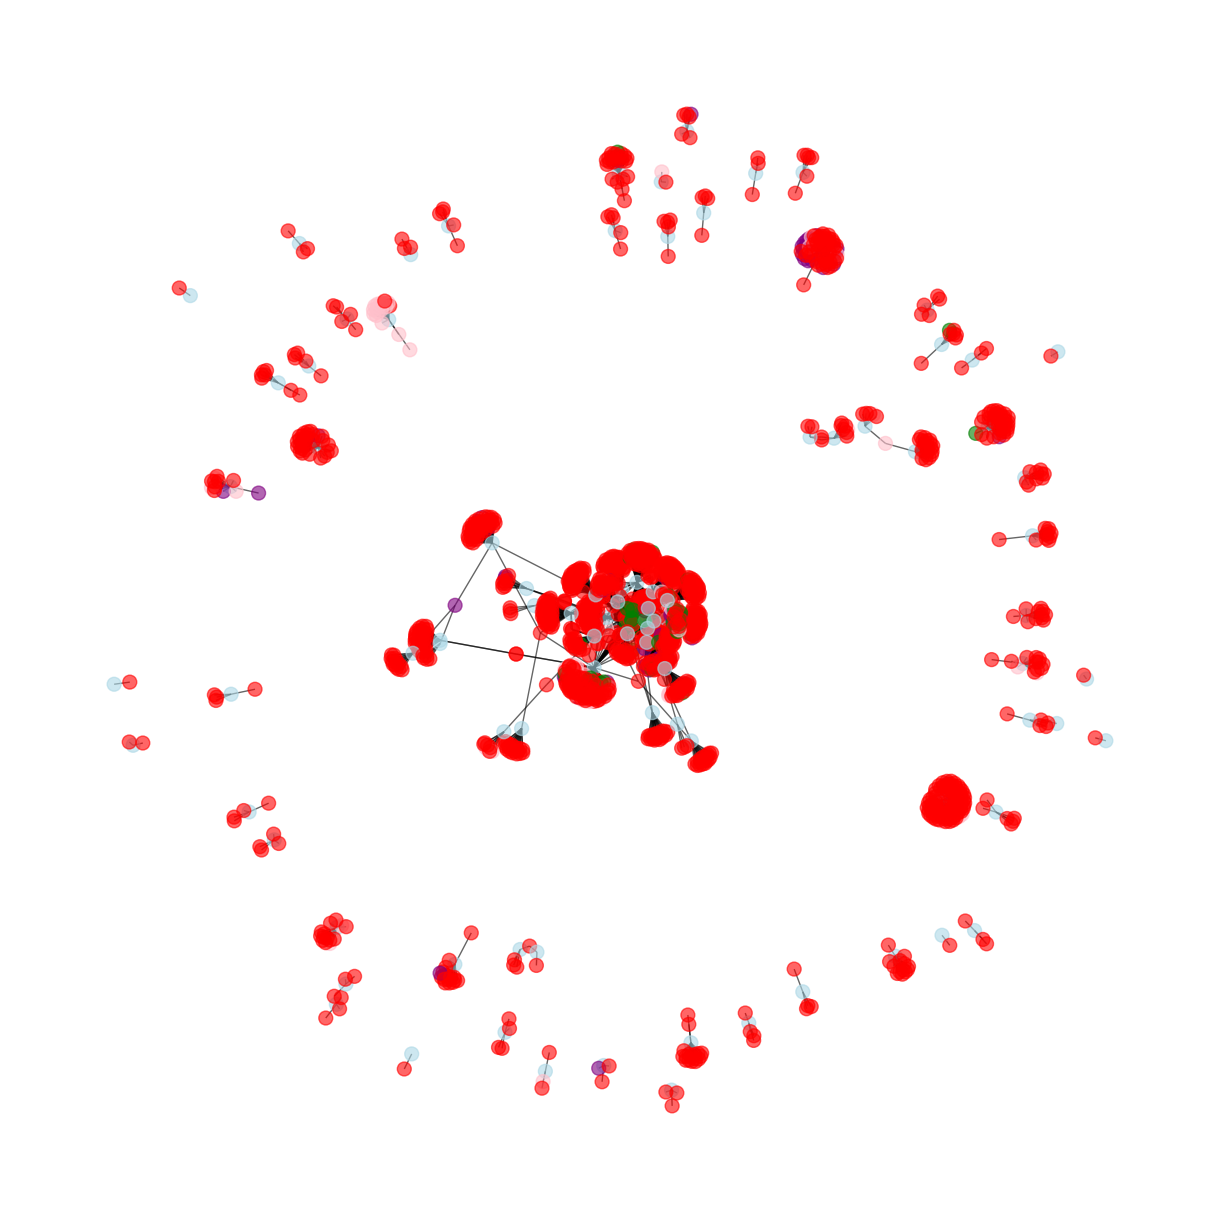

In [ ]:
plt.figure(figsize=(12, 12))

nx.draw(G, pos = pos, node_color=colors, alpha = 0.6, node_size = 100)

plt.show()

In [ ]:
communities = nx.algorithms.community.greedy_modularity_communities(G)

clear_communities = []

for com in communities:
    com_company_count = 0
    for node in com:
        if node in company:
            com_company_count+=1
    if com_company_count > 2:
        clear_communities.append(com)

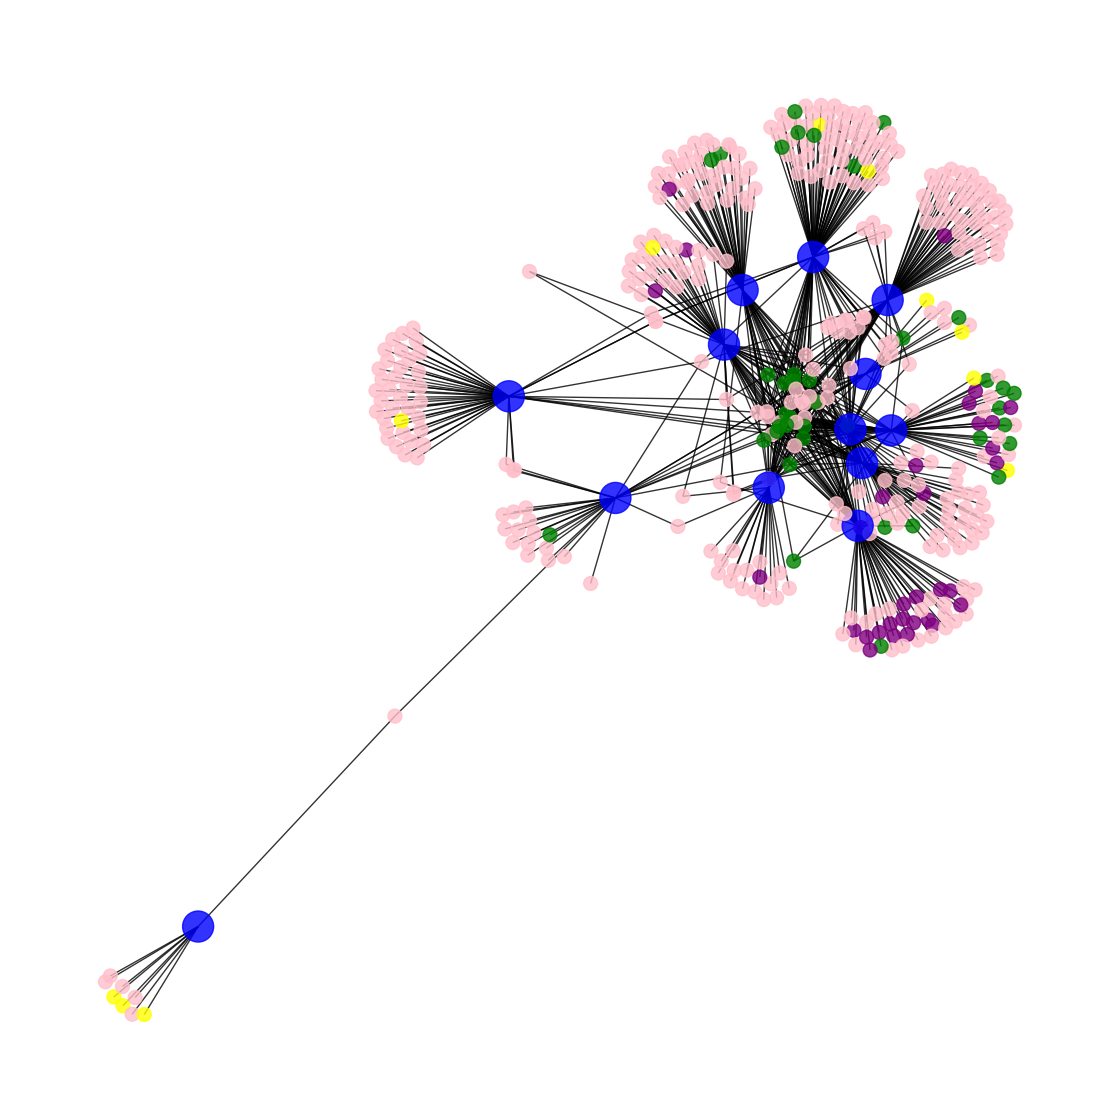

In [ ]:
plt.figure(figsize=(11, 11))

subgraph = G.subgraph(node for comm in clear_communities for node in comm)

colors = []
mask = {'Деловая тематика':'pink',
        'Другие происшествия':'green',
        'Корпоративные проблемы':'yellow',
        'Суды, конфликты, расследования':'purple'}
for node in subgraph.nodes:
    if node in df['Компания'].values:
        colors.append('blue')
    else: colors.append(mask[news_clustering[node]])

node_size = [500 if color == 'blue' else 100 for color in colors]

nx.draw(subgraph, pos = pos, node_color=colors, node_size = node_size, alpha = 0.8)

plt.show()